In [1]:
!pip install pint

In [2]:
import json, re, struct, pint
ureg = pint.UnitRegistry()

# Owon DSO Parser

Parse `.bin` files from DSOs like _Owon SDS1104_.
Tested with this specific model &ndash; likely works with
`.bin` files starting with `SPBXDS` from other models as well.


## Populate `data` from github
Adapt for other notebook environments or data sources.
`data` should contain a raw binary string with `.bin`
file's content.

In [3]:
import requests

url = 'https://github.com/varekc/owon-dso-bin/raw/main/samples/switch_contact_bounce.bin'
response = requests.get(url)

assert response.status_code == 200, f'Error fetching file: {response.status_code}'

data = response.content

## Check header

In [4]:
magic_header = data[0:6].decode('utf-8')
assert magic_header == 'SPBXDS', 'Binary data starts not with expected "SPBXDS" sequence!'

# current offset
offset = 6

## Get Meta Data

In [5]:
meta_data_length = int.from_bytes(data[offset:offset+4], byteorder='little', signed=False)
offset += 4
meta_data_length

682

In [6]:
meta_data_string = data[offset:offset+meta_data_length].decode('utf-8')
offset += meta_data_length
meta_data_string

'{"MODEL":"110400101","IDN":"OWON,SDS1104,24080326,V2.0.0","channel":[{"Index":"CH1","Availability_Flag":"TRUE","Display_Switch":"OFF","Wave_Character":"CH1","Sample_Rate":"(5MS/s)","Acqu_Mode":"SAMPle","Storage_Depth":"20K","Display_Mode":"Normal","Hscale":"200us","Vscale":"200mV","Reference_Zero":"0","Scroll_Pos_Time":"0.000000us","Trig_After_Time":"1196.000000us","Trig_Tops_Tme":"1196.000000us","Adc_Data_Time":"0.200000us","Adc_Data0_Time":"0.000000us","Voltage_Rate":"0.031250mv","Data_Length":"20000","Probe_Magnification":"10X","Current_Rate":10000.000000,"Current_Ratio":3.125000,"Measure_Current_Switch":"OFF","Cyc":"25565.281524us","Freq":"39.115548Hz","PRECISION":0},]}'

In [7]:
# Remove trailing commas before parsing
clean_json_string = re.sub(r',\s*([\]}])', r'\1', meta_data_string)

parsed_data = json.loads(clean_json_string)
parsed_data

{'MODEL': '110400101',
 'IDN': 'OWON,SDS1104,24080326,V2.0.0',
 'channel': [{'Index': 'CH1',
   'Availability_Flag': 'TRUE',
   'Display_Switch': 'OFF',
   'Wave_Character': 'CH1',
   'Sample_Rate': '(5MS/s)',
   'Acqu_Mode': 'SAMPle',
   'Storage_Depth': '20K',
   'Display_Mode': 'Normal',
   'Hscale': '200us',
   'Vscale': '200mV',
   'Reference_Zero': '0',
   'Scroll_Pos_Time': '0.000000us',
   'Trig_After_Time': '1196.000000us',
   'Trig_Tops_Tme': '1196.000000us',
   'Adc_Data_Time': '0.200000us',
   'Adc_Data0_Time': '0.000000us',
   'Voltage_Rate': '0.031250mv',
   'Data_Length': '20000',
   'Probe_Magnification': '10X',
   'Current_Rate': 10000.0,
   'Current_Ratio': 3.125,
   'Measure_Current_Switch': 'OFF',
   'Cyc': '25565.281524us',
   'Freq': '39.115548Hz',
   'PRECISION': 0}]}

## Get Waveform Data

For each channel get 4 bytes of length information
and then this number of signed small integers as
waveform data.

The waveform will be added as unscaled int array to the parsed
json metadata (property `Waveform_raw`) and scaled
to Seconds and Volts (property `Waveform'`).

In [8]:
for i in range(0, len(parsed_data['channel'])):
  wave_data_length = int.from_bytes(data[offset:offset+4], byteorder='little', signed=False)
  offset += 4
  wave_data_length

  # get signed small int values (each from two bytes of data)
  wave_data_bytes = data[offset:offset+wave_data_length]
  offset += wave_data_length
  wave_data = [
      struct.unpack_from('<h', wave_data_bytes, offset=i)[0]
      for i in range(0, len(wave_data_bytes), 2)]

  parsed_data['channel'][i]['Waveform_raw'] = wave_data

  # Scale prefixed units using pint; sample rates like '5MS/s' will be interpreted
  # as Siemens, so 5 Megasiemens per Second in this example.
  # This does not harm the prefix based scaling.
  sample_rate = ureg(parsed_data['channel'][i]['Sample_Rate']).to_base_units().m
  voltage_rate_str = re.sub(r'v$', 'V', parsed_data['channel'][i]['Voltage_Rate'])
  voltage_rate = ureg(voltage_rate_str).to_base_units().m
  probe_magnification = int(re.match(r'(\d+)', parsed_data['channel'][i]['Probe_Magnification']).group(1))
  trigger_time = 0 #ureg(parsed_data['channel'][i]['Trig_After_Time']).to_base_units().m
  parsed_data['channel'][i]['Waveform'] = {
      't': [i/sample_rate-trigger_time for i in range(0, len(wave_data))],
      'v': [i*voltage_rate*probe_magnification for i in wave_data]
  }

## Plot Waveforms

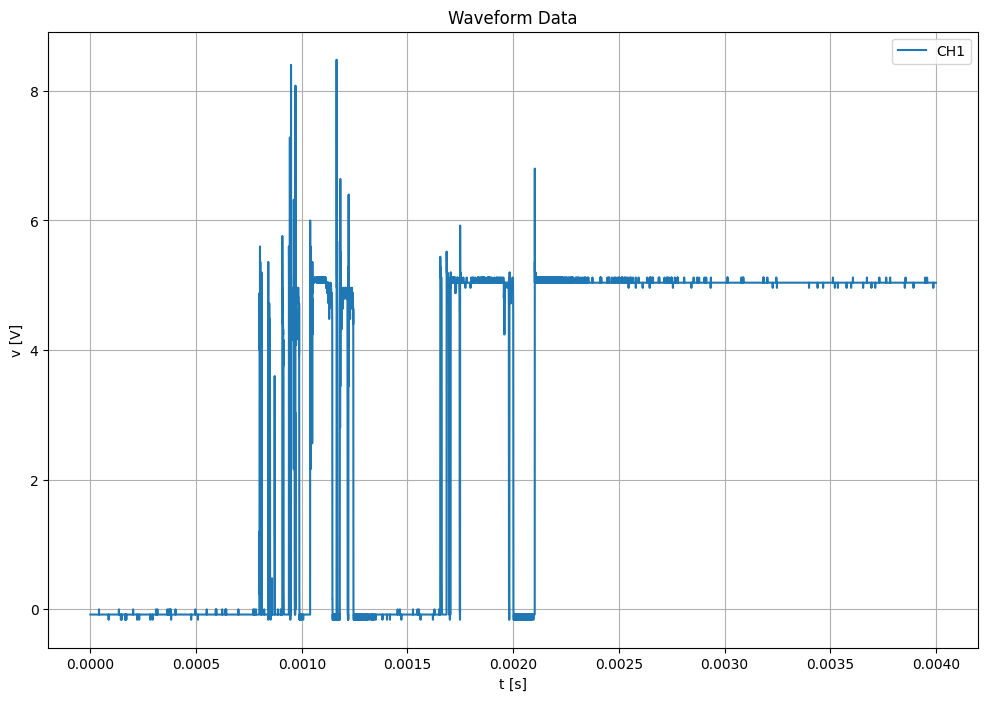

In [9]:
import matplotlib.pyplot as plt

# Create a plot for each waveform, labeled by its 'Index'
plt.figure(figsize=(12, 8))

for item in parsed_data['channel']:
    channel = item['Index']
    waveform = item['Waveform']
    plt.plot(waveform['t'], waveform['v'], label=channel)

# Add titles and labels
plt.title('Waveform Data')
plt.xlabel('t [s]')
plt.ylabel('v [V]')
plt.legend()
plt.grid(True)
plt.show()